In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
file_list = []
for index in range(16):
    caminho_do_arquivo = f'../data/summary_{index}.csv'
    file_list.append(caminho_do_arquivo)

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df.head(2)

,time,loaded,inserted,running,waiting,ended,arrived,collisions,teleports,halting,...,meanWaitingTime,meanTravelTime,meanSpeed,meanSpeedRelative,duration,ALGORITHM,PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT,TRIPS_REPETITION_RATE,SIMULATION_END_TIME,EXP_ID
0,0.0,2,1,1,0,0,0,0,0,1,...,0.0,-1.0,0.00,0.00,0,default,1.0,1.0,800,default-1.0-1.0-800
1,1.0,2,1,1,0,0,0,0,0,0,...,0.0,-1.0,1.79,0.13,0,default,1.0,1.0,800,default-1.0-1.0-800


In [3]:
df.dtypes

time                                                   float64
loaded                                                   int64
inserted                                                 int64
running                                                  int64
waiting                                                  int64
ended                                                    int64
arrived                                                  int64
collisions                                               int64
teleports                                                int64
halting                                                  int64
stopped                                                  int64
meanWaitingTime                                        float64
meanTravelTime                                         float64
meanSpeed                                              float64
meanSpeedRelative                                      float64
duration                                               

In [4]:
lista_index = ['ALGORITHM', 'PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT', 'TRIPS_REPETITION_RATE','SIMULATION_END_TIME']
var_resposta = list(set(df.columns) - set(lista_index+['EXP_ID', 'arrived', 'time', 'duration', 'teleports', 'collisions', 'ended', 'stopped', 'loaded', 'running']))
var_resposta

['meanSpeedRelative',
 'arrived',
 'time',
 'duration',
 'teleports',
 'waiting',
 'inserted',
 'meanWaitingTime',
 'halting',
 'meanSpeed',
 'collisions',
 'ended',
 'meanTravelTime',
 'stopped',
 'loaded',
 'running']

In [5]:
grouped = df.drop(columns=['EXP_ID']).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

grouped.head(2)

ALGORITHM PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT  \
                                                                  
0   default                                                1.0    
1   default                                                1.0    

  TRIPS_REPETITION_RATE SIMULATION_END_TIME   time                  loaded  \
                                              mean         std        mean   
0                   1.0                 800  400.0  231.373075  257.425718   
1                   1.0                1600  800.0  462.313206  464.036227   

                 inserted              ... meanWaitingTime meanTravelTime  \
          std        mean         std  ...             std           mean   
0  116.712445  202.307116  116.937635  ...        0.155341      96.107965   
1  237.796481  403.482823  232.524563  ...        0.350853     111.716646   

             meanSpeed           meanSpeedRelative            duration  \
         std      mean       std              mean       std      mean   
0  34.938364  5.355743  2.232176          0.432210  0.159367  0.394507   
1  29.268903  4.581599  2.132513          0.408844  0.146731  0.519675   

                               id  
        std                        
0  0.564951   default-1.0-1.0-800  
1  0.611162  default-1.0-1.0-1600  

[2 rows x 37 columns]

In [6]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [7]:
calc_interval(grouped=grouped, var_resposta=var_resposta)

In [8]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}
num_factors, factor_levels_real

(4,
 {'ALGORITHM': ['default', 'proposto'],
  'PROPORTION_DELAY_CALL_EMERGENCY_VEHICLE_TO_ACCIDENT': [1.0, 1.2],
  'TRIPS_REPETITION_RATE': [1.0, 2.0],
  'SIMULATION_END_TIME': [800, 1600]})

In [9]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta
num_response_vars, response_vars_names

(16,
 ['meanSpeedRelative',
  'arrived',
  'time',
  'duration',
  'teleports',
  'waiting',
  'inserted',
  'meanWaitingTime',
  'halting',
  'meanSpeed',
  'collisions',
  'ended',
  'meanTravelTime',
  'stopped',
  'loaded',
  'running'])

In [10]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors
# total_experiments

In [11]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))
# level_combinations, experiment_design_df

In [12]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']
# experiment_design_df

In [13]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)

In [14]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})

In [15]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

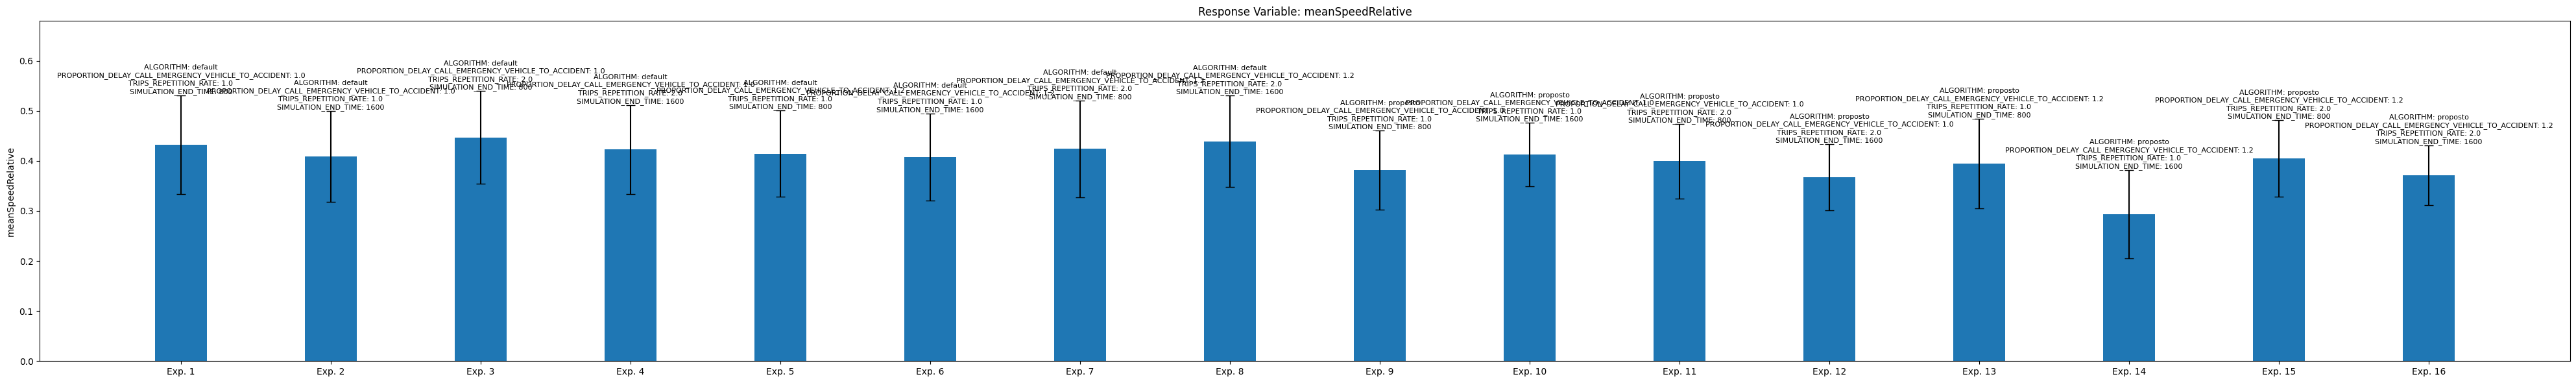

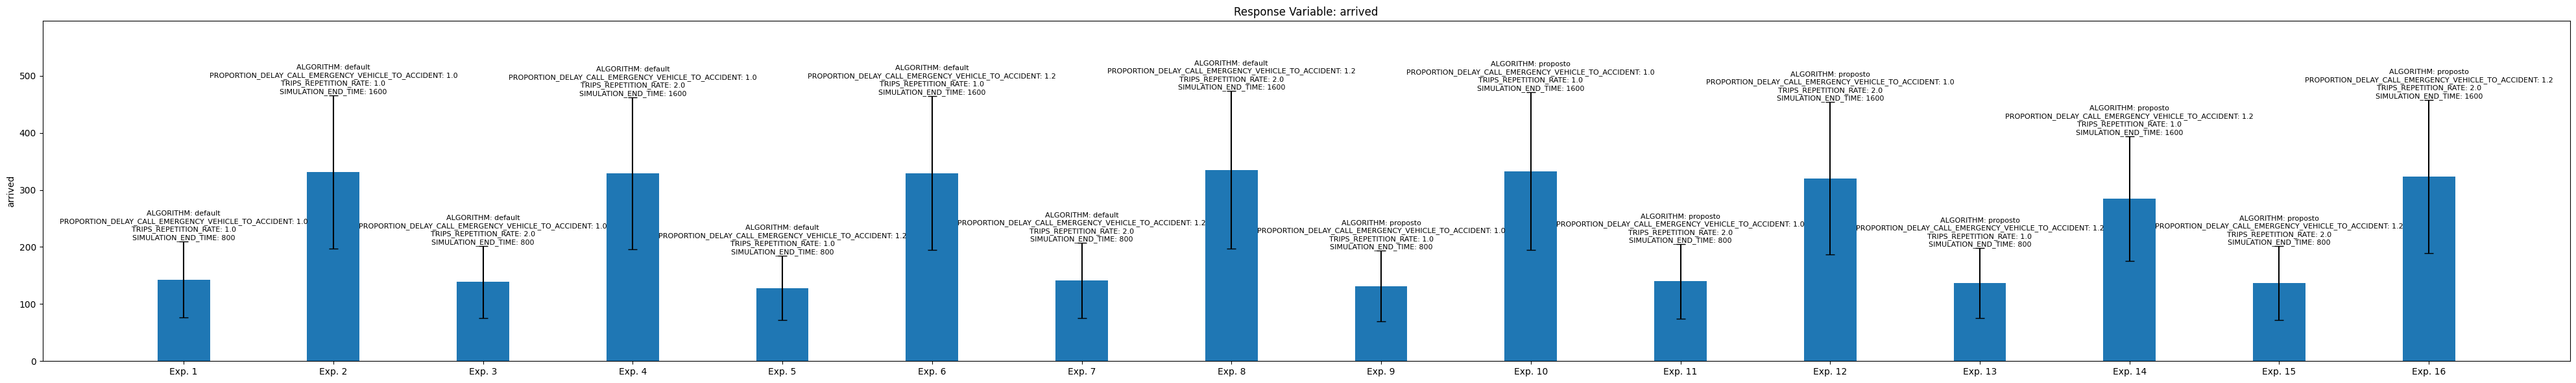

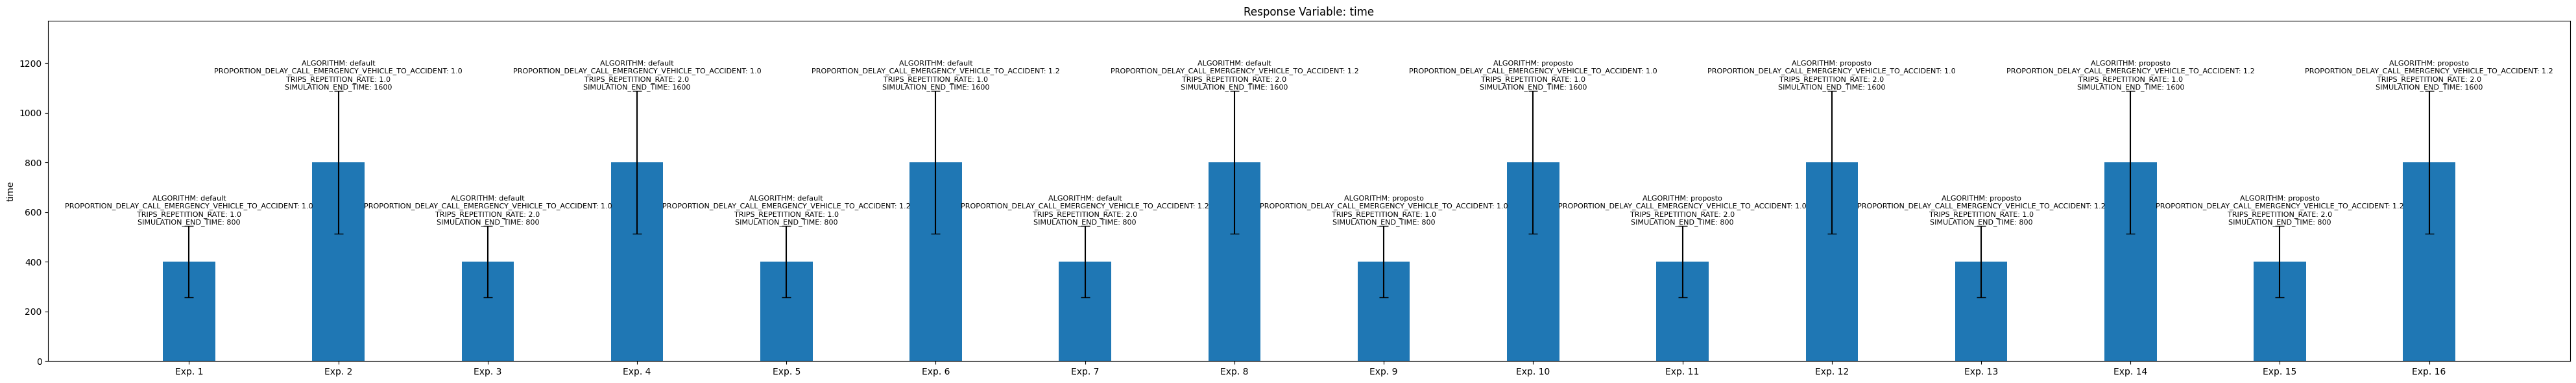

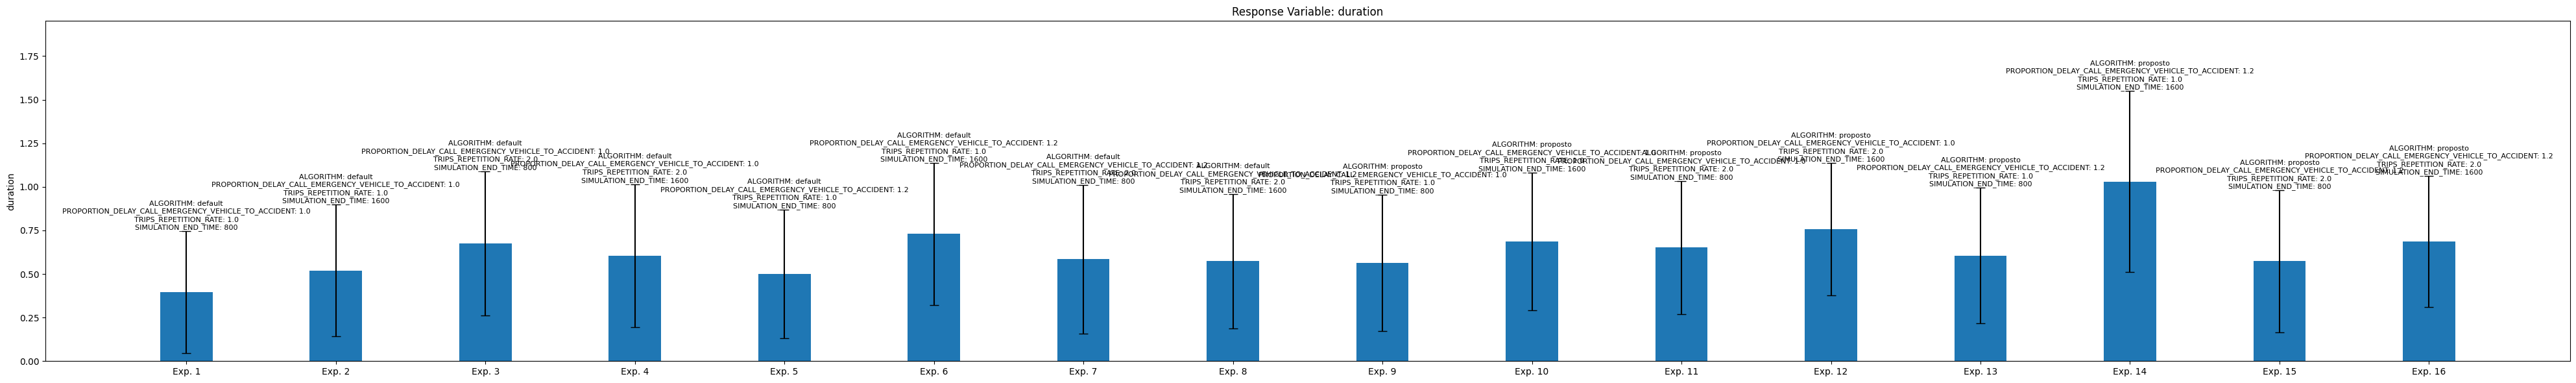

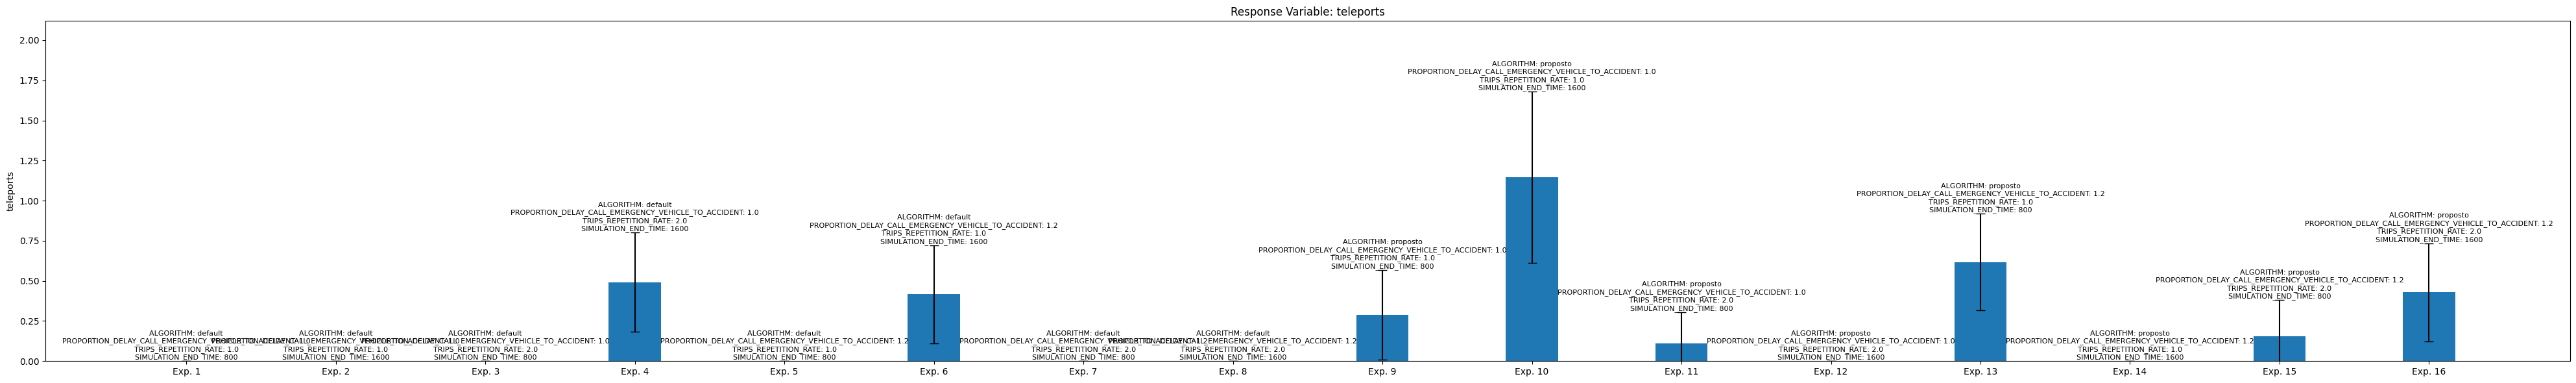

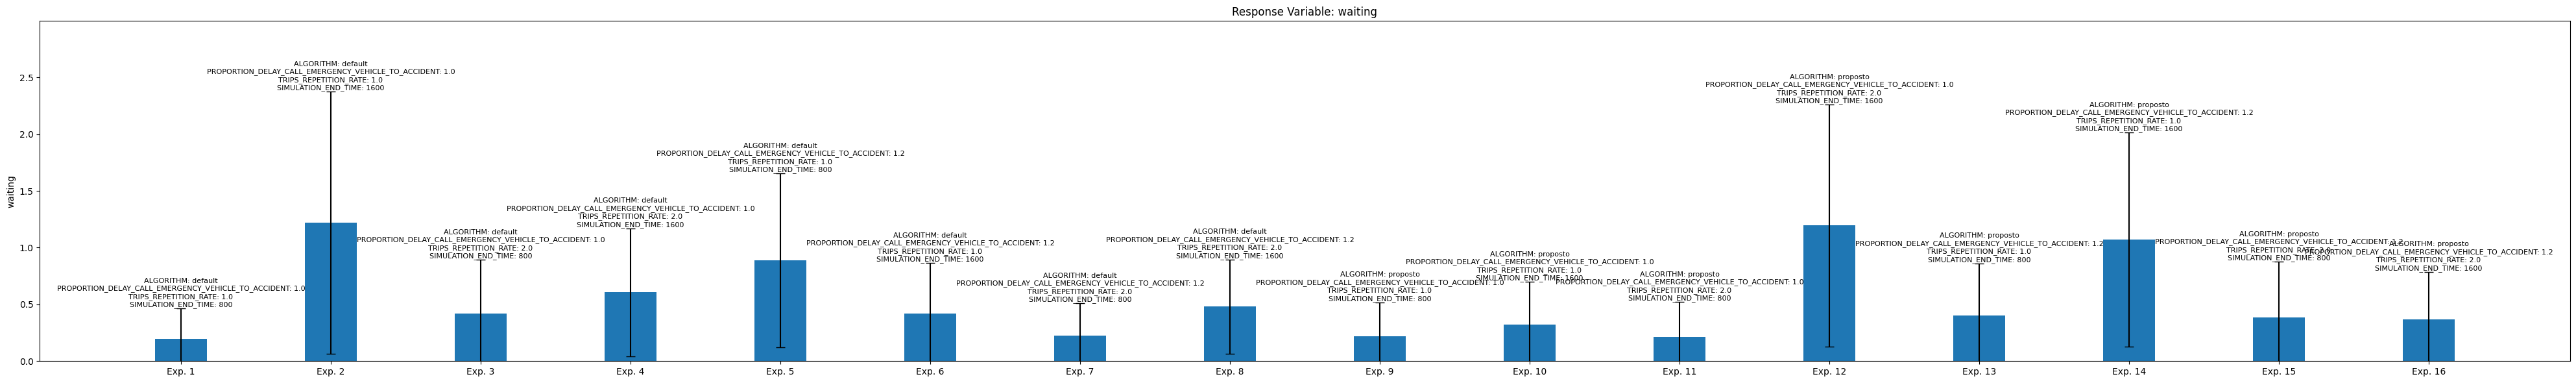

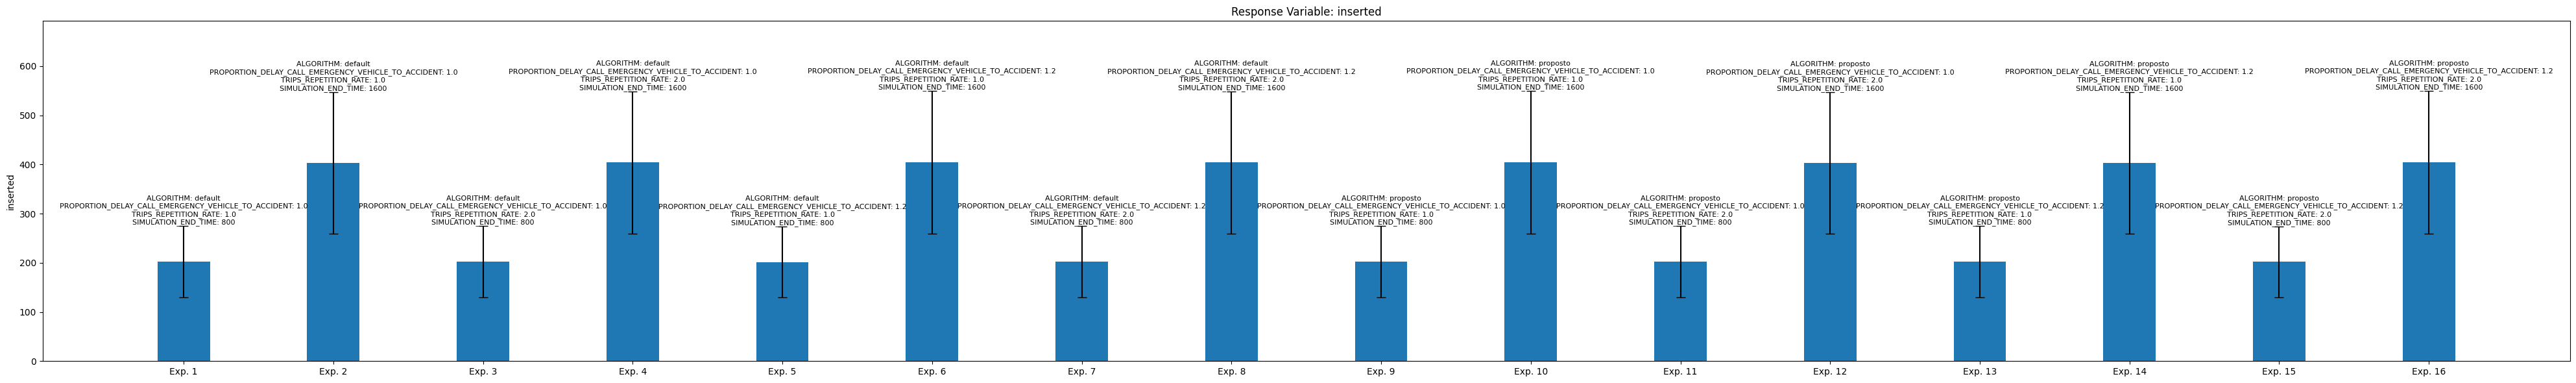

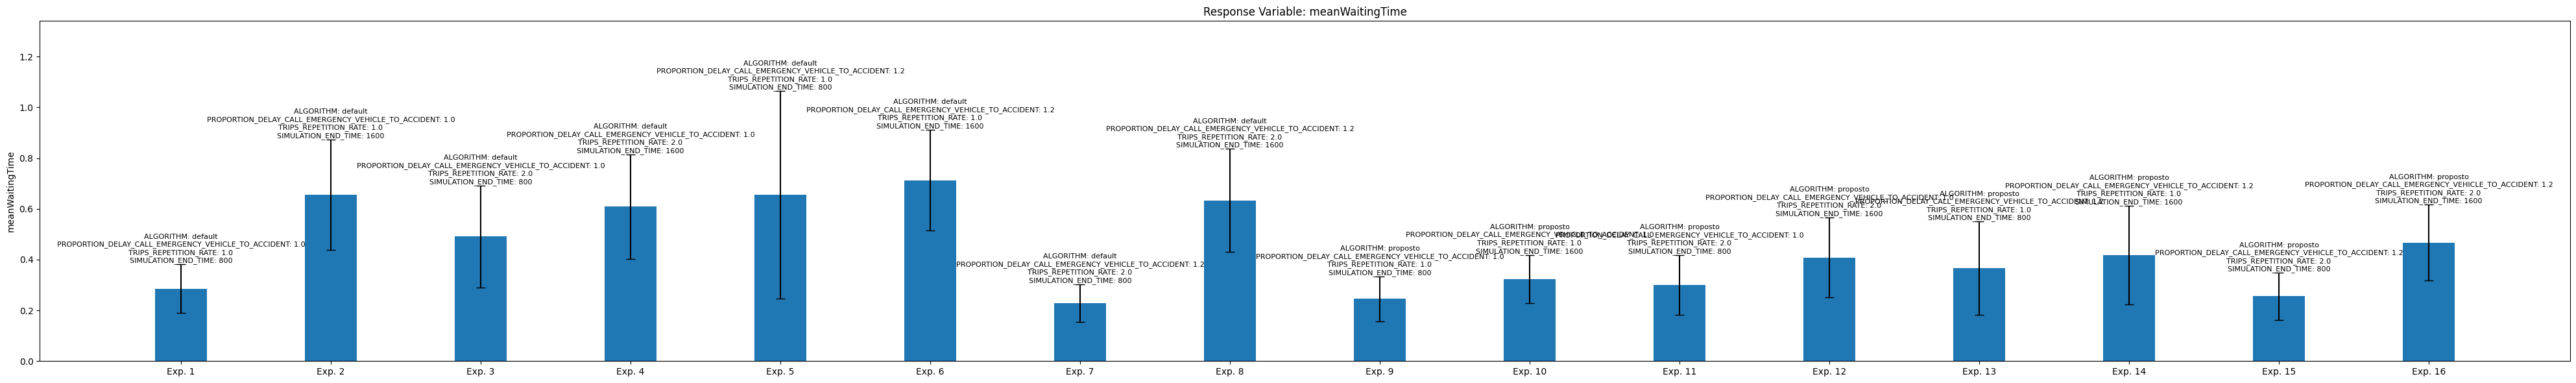

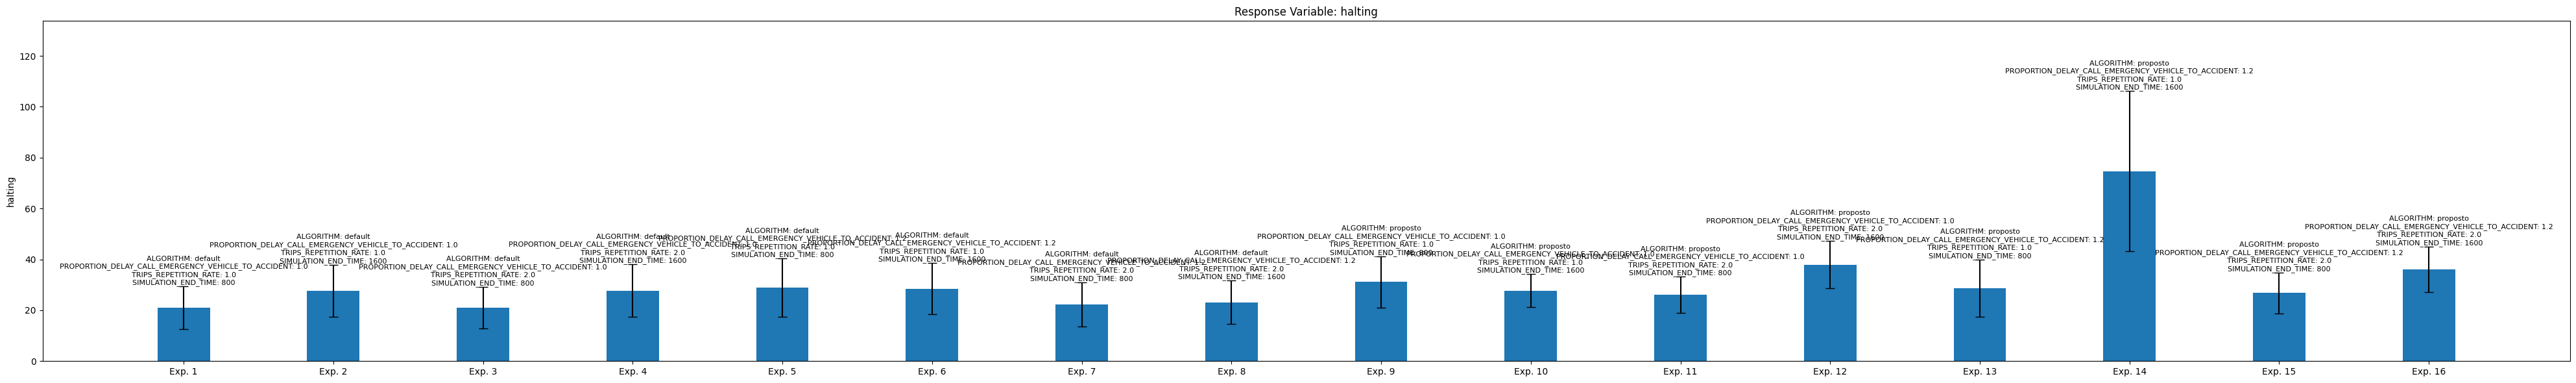

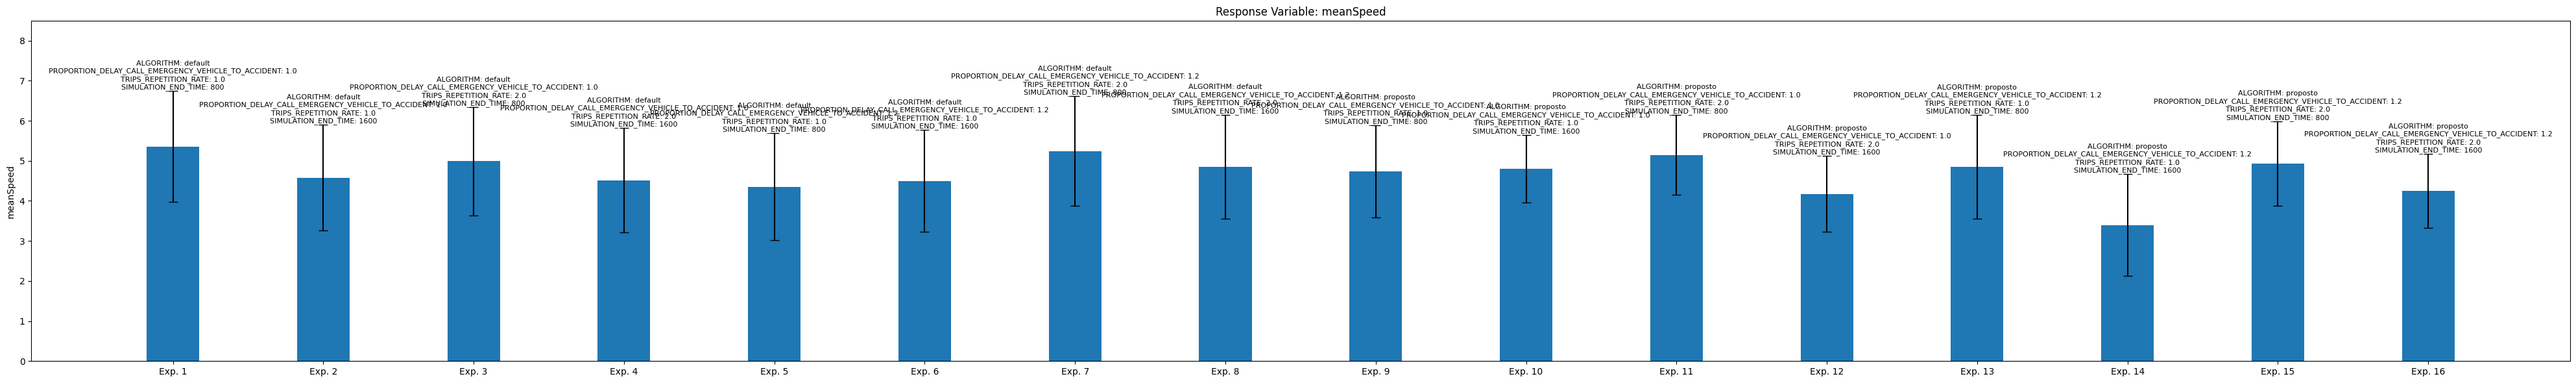

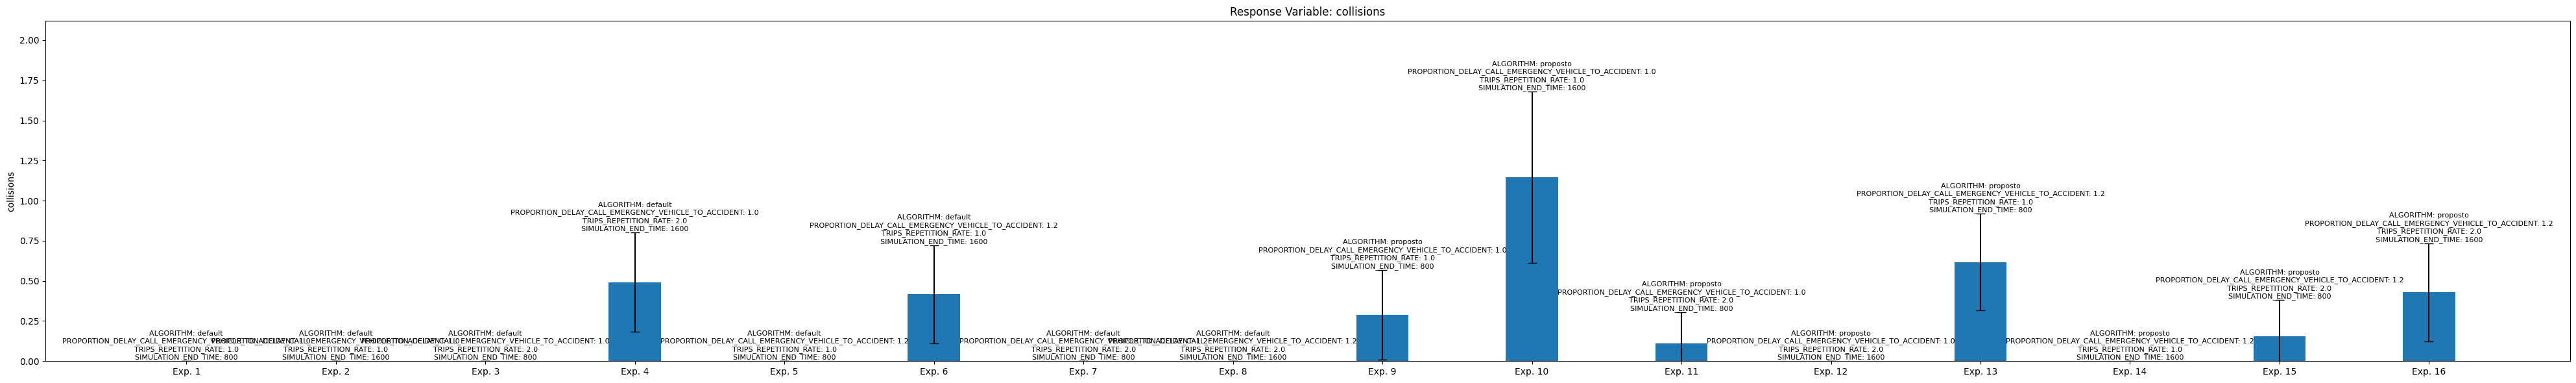

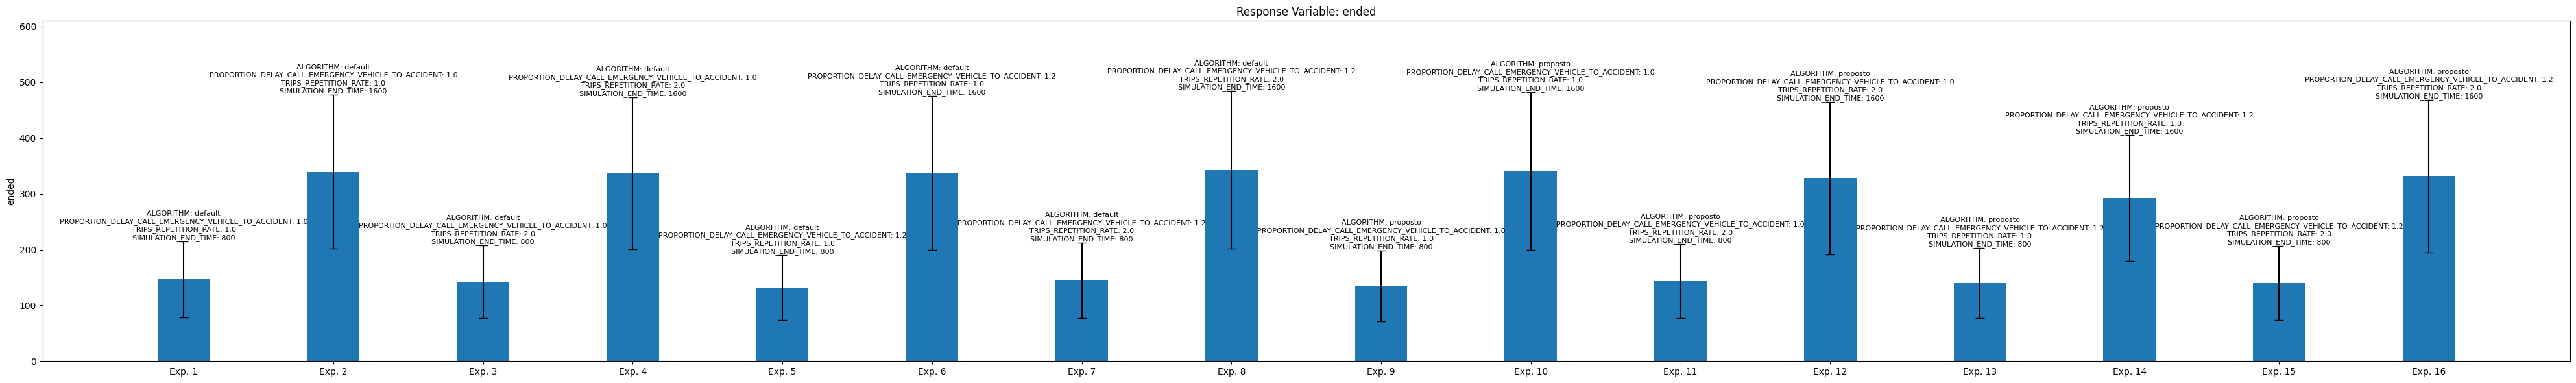

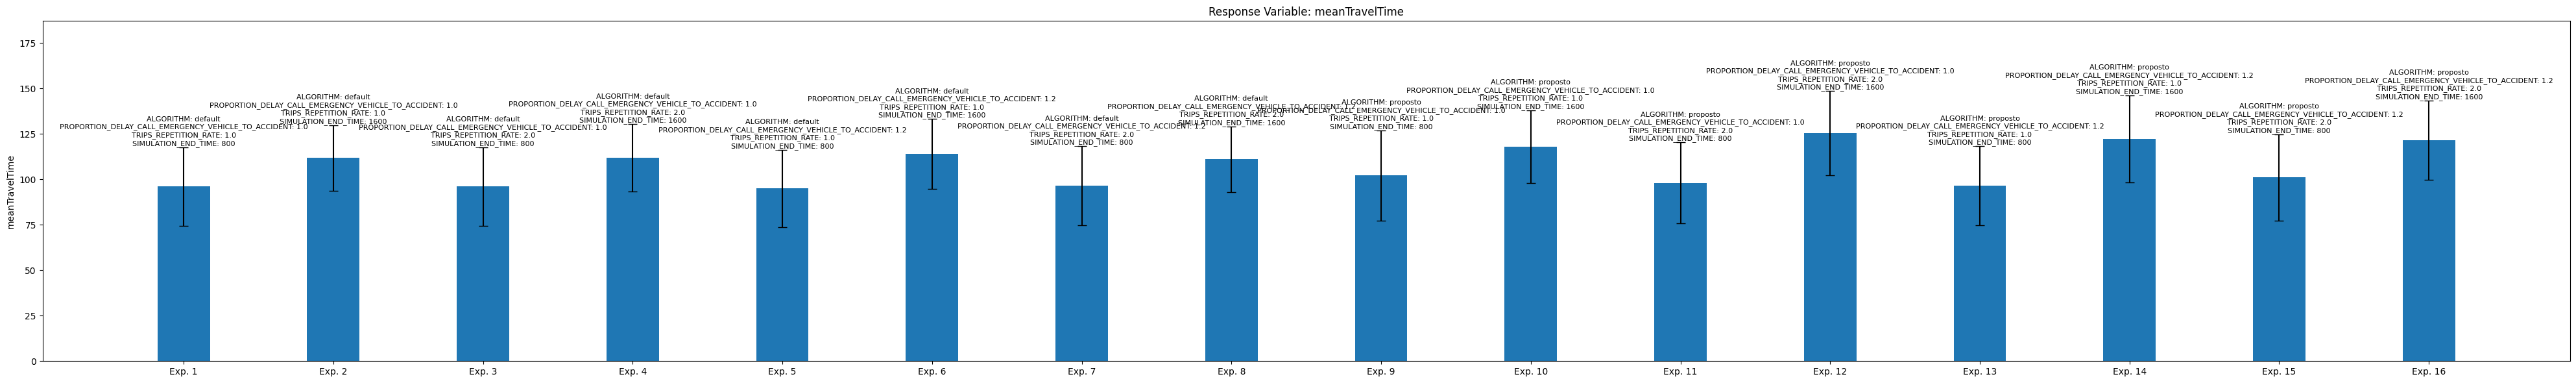

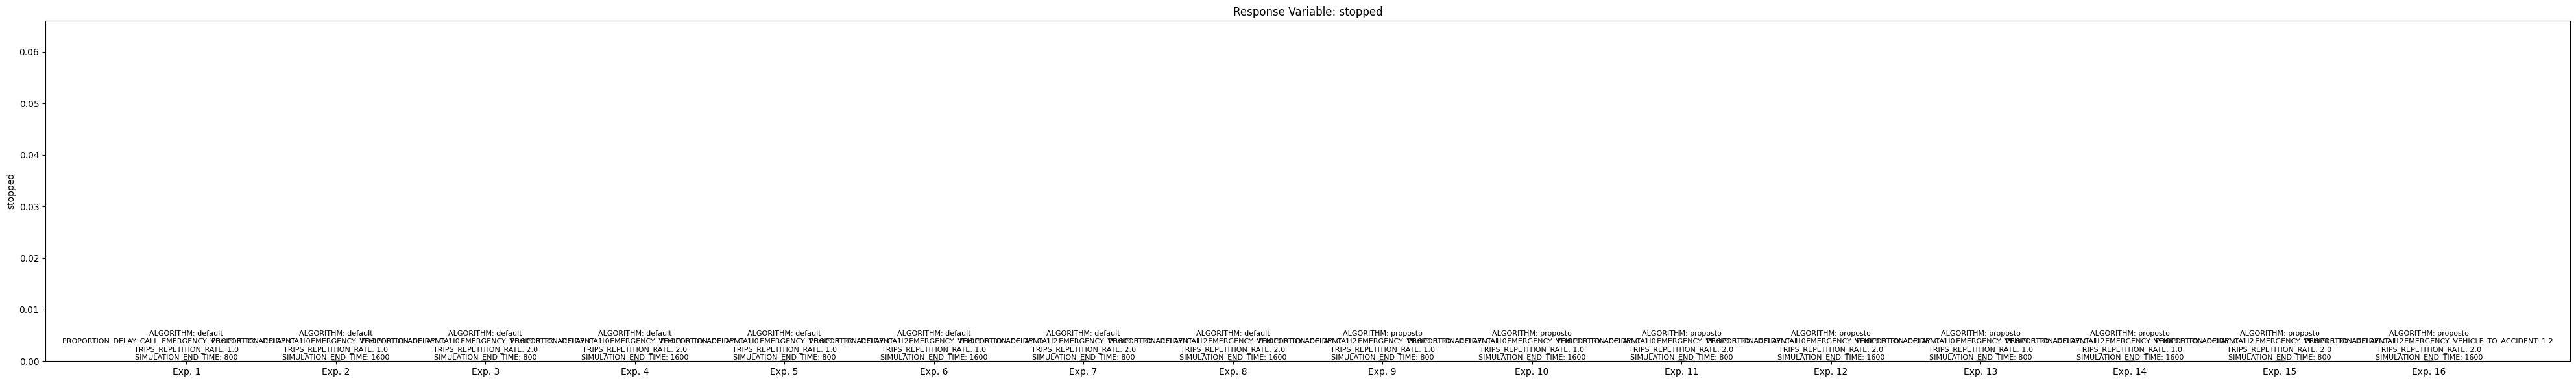

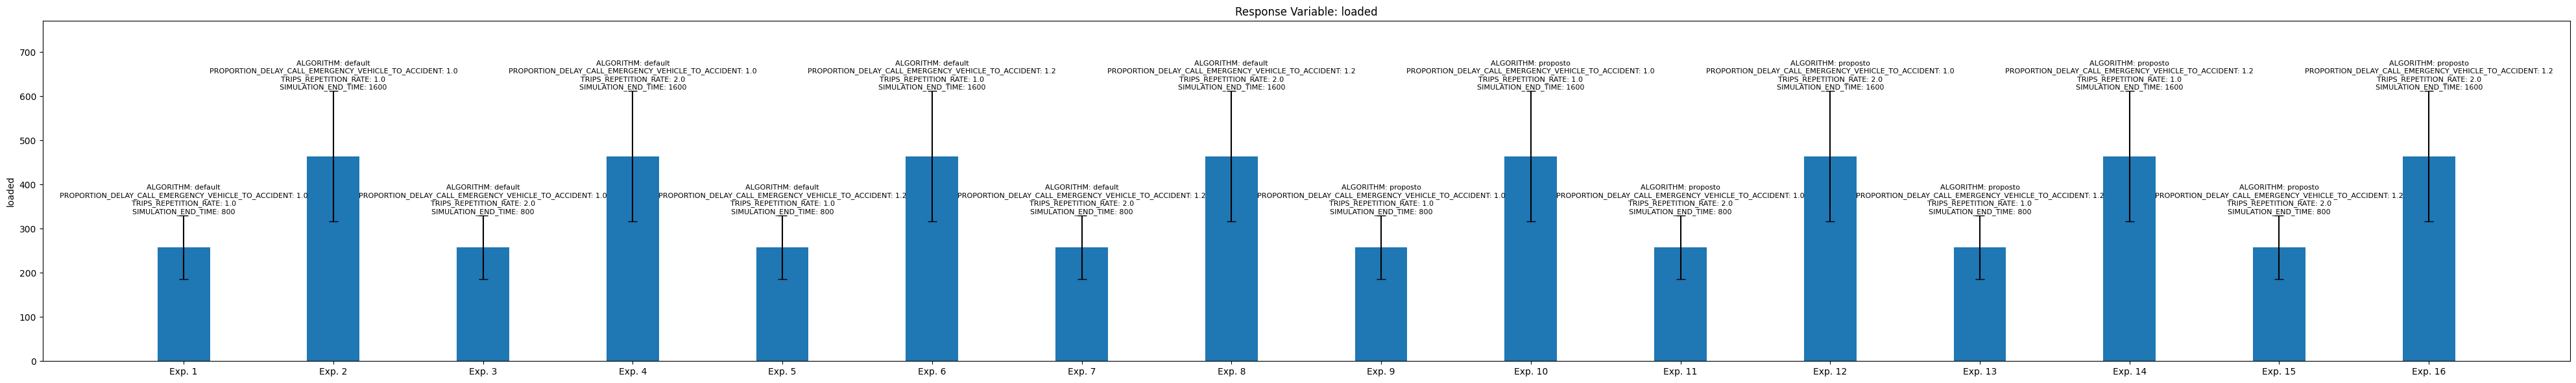

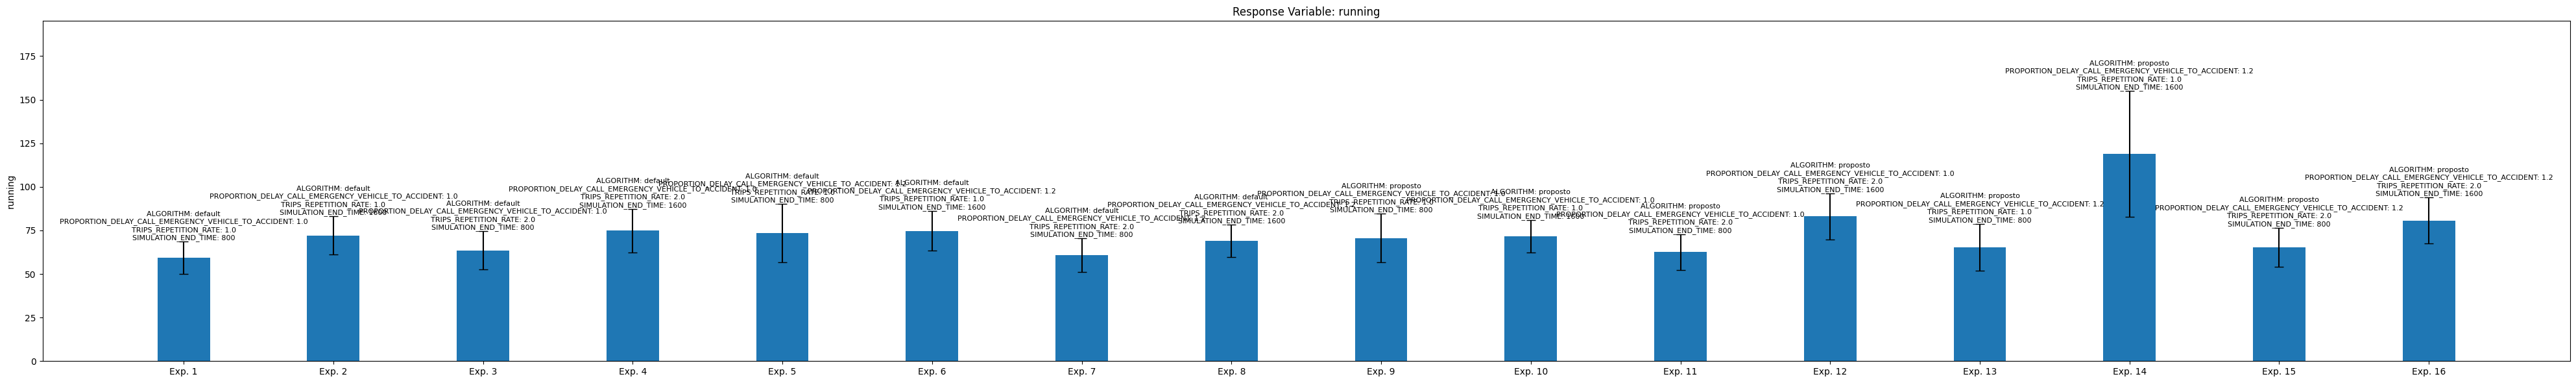

In [16]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    plt.savefig('../plot/Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()
